# <font size =20> **Subject Processing Notebook** </font>

---


<font color = "\#8FBC8F">code under a title with this color has to run</font>

---

# <font color = "\#8FBC8F">**Initialization**


In [ ]:
#@title <font color="\#8FBC8F">Google Drive mount

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title <font color="\#8FBC8F">Imports

import os
import pdb
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.dpi'] = 100


!pip install mne --upgrade --quiet
import mne

from mne.filter import notch_filter as notch
from mne.time_frequency import tfr_morlet as morl
from mne.time_frequency import tfr_array_morlet as amorl

from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split as Split

print('[imports successfully loaded]')

     |████████████████████████████████| 7.0MB 5.4MB/s 
[imports successfully loaded]


In [ ]:
#@title <font color="\#8FBC8F"> Feature Manager Class

class WTFeatureManager:
    dt = 200#@param {type:'integer'} 
    sfreq = 250 # [Hz]
    f_bands = [0, 4, 8, 13, 30, 60, 80]
    f_names = ['Delta', 'Theta', 'Alpha', 'Beta', 'low-Gamma', 'high-Gamma']
       
    wt_frequencies = np.geomspace(1, 80)
    
    def __init__(self, data, ch_names=None):
        # data is an array - array([epochs, channels, frequencies, time(samles)])
        self.data = data
        self.n_epochs, self.n_channels, self.n_freq, self.n_samp = data.shape

        # channel names will be necesarry for importance retrieval
        self.ch_names = ch_names
      
        # this is the number of samples per bin
        self.dsamp = int(self.sfreq*self.dt*1e-3)

        # this is an iterator of t0 for each bin
        self.t_bins = np.arange(0, self.n_samp, self.dsamp)
        
        # this is a dict - {'f_band':[wt frequency indices of f_band]}
        self.f_idx = self._get_freq_indices()

        # number of bins in every wt
        self.bins_per_wt = len(self.f_names)*len(self.t_bins)
        
        # returns bin relevant data & metadata
        self.binerator = self._binerator()

        # this sets the wt to the first epoch and channel by default, but
        # it updates during the
        self.wt_bins = self._wt_2d_bin()

        # this is a list of tuples - each looks as follows:
        # [(epoch_number, channel_index, band_name, time_0_of_bin)]
        self.bin_metadata = []
        self.bin_features = {}

    def _get_freq_indices(self):
        """
        This function returns a dict of indices, where the keys are the 
        frequency band names, and the values are the ones you'll want to take 
        from the wavelet transform channel 2D array
        """
        f_idx = {}
        for bi,b in enumerate(self.f_bands):
            if bi == len(self.f_bands)-1: break
            f_idx[self.f_names[bi]] = []
            for fi, f in enumerate(self.wt_frequencies):
                if b<f<=self.f_bands[bi+1]: f_idx[self.f_names[bi]].append(fi)
        return f_idx

    def _binerator(self):
        """
        This is a generator that yields bin data and metadata
        Will need a reset for each epoch/channel
        """
        for band, i_freq in self.f_idx.items():
            for t0 in self.t_bins:
                yield (band, i_freq, t0)

    def _wt_2d_bin(self, epoch=0, channel=0):
        """
        This is a generator that stores metadata and yields wt_data_bin
        doesn't need to be reset for every epoch/channel
        """
        wt = self.data[epoch, channel]
        for band, i_f_list, t0 in self.binerator:
            self.bin_metadata.append((epoch, channel, 
                                      band, t0 * self.dt // self.dsamp))
            yield wt[i_f_list, t0:t0+self.dsamp]
    
    # features are declared here as a class variable since they're
    # not supposed to change when the right ones are selected
    feats = ['min','max','mean','std','median']

    def features_from_wt(self):
        """
        This function takes features from the curently selected wt_bins instance
        and stores them in the bin_features dict where the metadata for each bin
        is the key, and the features are the values

        To process a different wt_bins object, you must re initiate the wt_bins 
        object with correct epoch and channel numbers before running this function
        """
        for bin in self.wt_bins: 
            md = self.bin_metadata[-1]
            self.bin_features[md] = []

            # bin is of type np.ndarray
            # TODO: uncomment
            self.bin_features[md].append(bin.min())
            self.bin_features[md].append(bin.max())
            self.bin_features[md].append(bin.mean())
            self.bin_features[md].append(bin.std())
            self.bin_features[md].append(np.median(bin))

    def all_ep_ch_feature_extraction(self, norm=False):
        """
        This function will extract all of the features for a subject
        """
        for ep in tqdm(range(self.n_epochs), desc='Epoch:'):

            for ch in range(self.n_channels):

                self.binerator = self._binerator()
                self.wt_bins = self._wt_2d_bin(ep,ch)
                self.features_from_wt()
    
    def as_dataframe(self, norm=False):
        self.all_ep_ch_feature_extraction(norm)
        
        print('[Creating DataFrame]')
        df = pd.DataFrame(self.bin_features).T

        idx_names = ['Epoch', 'Channel_Number', 'Freq_Band', 'T0 [ms]']
        
        df.index.set_names(names=idx_names, inplace=True)
        
        df.rename(columns={k:v for k,v in zip(range(len(self.feats)),self.feats)}, inplace=True)
        df.reset_index(inplace=True)
        
        return df.pivot(idx_names[0],idx_names[1:],self.feats)

print('[Class WTFeatureManager successfully loaded]')

[Class WTFeatureManager successfully loaded]



---

# <font color = "\#8FBC8F">**Loading Data**</font> 





In [ ]:
#@title <font color="\#8FBC8F">File loading utility code

subject_index =  0#@param {type:'integer'}
DATA_DIR = r'/content/drive/MyDrive/Colab Notebooks/Project Domino/new Macros/'
subject_list = sorted([f for f in os.listdir(DATA_DIR) if 'sub' in f])

subject_path = DATA_DIR + f'{subject_list[subject_index]}/'
subject_files = os.listdir(subject_path)

if 'sub' not in locals() or sub != subject_list[subject_index]:
    sub = subject_list[subject_index] 

print(f'[Working on {subject_list[subject_index]}]')

[Working on sub-006]


In [ ]:
#@title <font color="\#8FBC8F">Load Files
X_name = subject_path + f'/{subject_list[subject_index]}_X.npy'
y_name = subject_path + f'/{subject_list[subject_index]}_y.npy'
names_name = subject_path + f'{subject_list[subject_index]}_channel_names.npy'

_X = np.load(X_name)
_y = np.load(y_name)
ch_names = np.load(names_name)
print(f'[Loaded X, y and channel names data succesfully]')

[Loaded X, y and channel names data succesfully]


In [ ]:
#@title <font color="\#8FBC8F">WT Feature Extraction

wtfm = WTFeatureManager(_X, ch_names)
print(f'[Extracting {wtfm.feats} from each bin]')

X = wtfm.as_dataframe()
y = pd.DataFrame(_y, columns=['label'])

print(f'[X and y loaded successfully]')

del _X, _y

Epoch::   0%|          | 0/49 [00:00<?, ?it/s]

[Extracting ['min', 'max', 'mean', 'std', 'median'] from each bin]


Epoch:: 100%|██████████| 49/49 [00:35<00:00,  1.38it/s]


[Creating DataFrame]
[X and y loaded successfully]


# <font color='darkgreen'>**Pickle**

In [ ]:
#@title <font color='darkgreen'>Pickle X and y - Utility
import datetime as dt


now = (str(dt.datetime.now())[:-7]).replace(' ', '_')

pickle_path = f'/content/drive/My Drive/Colab Notebooks/Project Domino/Feature-Label matrices/{sub}/'

if not os.path.isdir(pickle_path): os.mkdir(pickle_path)
os.mkdir(pickle_path+now)

f_last = f'{sub}_last.txt'
with open(pickle_path+f_last, 'w') as f:
    f.write(now)


if 'label' in X.columns: X.drop('label', axis=1, inplace=True)

X.to_pickle(pickle_path + now + '/X.pickle')
y.to_pickle(pickle_path + now + '/y.pickle')


with open(pickle_path + now + '/log.txt', 'w') as f:
    f.write(
        f'''
subject number:     {sub}
bin features:       {WTFeatureManager.feats}
bin time:           {WTFeatureManager.dt} [ms]
        '''
    )

with open(pickle_path[:-1*(len(sub)+1)] + 'last.txt', 'w') as f:
    f.write(now + ' ' + sub)

# del _X,_y, X, y

In [ ]:
#@title <font color='darkgreen'>Unpickle X and y - Utility
#@markdown This might need some correction of where to load last date from

with open(pickle_path[:-8] + 'last.txt', 'r') as f:
            last_date, sub = f.read().split()
             
pickle_path = f'/content/drive/My Drive/Colab Notebooks/Project Domino/Feature-Label matrices/{sub}/'

if '_X' not in locals() or '_y' not in locals():
    try:
        _X = pd.read_pickle(pickle_path + last_date +'/X.pickle')
        _y = pd.read_pickle(pickle_path + last_date +'/y.pickle')
        X, y = _X, _y
        print('[Successfully loaded X and y]')
    except Exception as e:
        print(e)
else:
    X, y = _X.copy(), _y.copy()
    print('{X and y exist}')

[Successfully loaded X and y]


---


# <font color = "\#C9EBE4">**Per patient calssification:**


**Done!**

> <font color = "\#C9EBE4">divide to frequency bands [ alpha, beta, gamma, theta ]

> <font color = "\#C9EBE4">divide time to ~100ms bins




> <font color = "\#C9EBE4">normalization - for each epoch, divide CWT by mean CWT (mean over epocs per channel) - look out for leakage

Normalization is an open issue due to **leakage** issues

Currently I fit a standard normalizer on X_train and transform X_train & X_test.

This makes the classifiers choose more than just 1 label, like they did befor normalizing/with MinMaxScalar Normalization

This is an across-epoch normalization

Additional normalization techniques need to be taken in account - Wavelet transform normalization/ across channels/ trials/






PCA will be considered in the future

> <font color = "\#C9EBE4">(opt. - PCA for within group electrde)


> <font color = "\#C9EBE4">create per patient classifier + feature engneering (statistics for every bin)

> <font color = "\#C9EBE4">read about classifiers: SVM, Gaussian regression model, CNN(?), RNN(?)


---

## Util.

In [ ]:
#@title Uncomment the last 2 lines to plot Epoch 0 wavelet transform per channel

def plot_morlet(mrl, ep, r=4, c=4, norm=False, log=False):
    '''
    This function gets the wavelet transform and epoch number
    and plots out an r-by-c subplots of the epoch's wavelet
    transform output
    norm and log are transforms used to 
    '''
    avg_spectrum = mrl.data[ep].mean(axis=0)

    for n in range(int(len(mrl[0].ch_names) / (r * c)) + 1):
        fig, axs = plt.subplots(r, c, figsize=(12,12))

        for i in range(r * c):
            try:
                ax = axs[int(i / c), i % c]
                plot_data = mrl.data[ep, r * c * n + i]
                if norm: plot_data = mrl.data[ep, r * c * n + i] / avg_spectrum

                im = ax.imshow(plot_data, aspect='auto', extent=[-2, 8, 100, 1])
                if log: ax.set_yscale('log')

                ax.set_title(mrl.ch_names[r * c * n + i], fontsize=8)
                fig.colorbar(im, ax=ax)
                # print(f'plotted ch number {r * c * n + i}')
            except Exception as e:
                ax.remove()
                pass
        plt.tight_layout()
        plt.show()
    

epoch_number = 0


# mrl0 = subj.get_morlet(set_number=0, freqs=np.geomspace(1, 100), n_cycles=np.geomspace(3, 24))
# plot_morlet(mrl0, ep=epoch_number, norm=True, log=True)

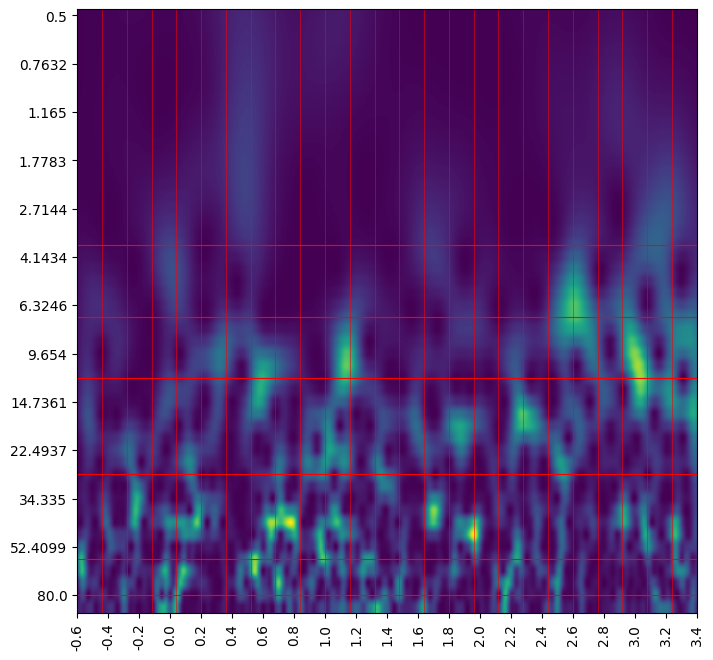

In [ ]:
#@title WT bin division

ds = 250; 
x_res, y_res = _X.shape[3], _X.shape[2] # time X frequency
times = ([round(n, ndigits=4) for n in np.arange(-0.6, 3.4+1/250, 1/250)])
x_bin_lines = np.array([np.arange(0,x_res+1, wtfm.dt),]*(y_res+1))

bands = wtfm.f_bands[1:]
freqs = np.geomspace(0.5, 80, 50)
y_idxs = [np.where(b>=freqs)[0][-1] for b in bands]

y_bin_lines = np.array([(y_idxs),]*x_res)-1

_ = plt.imshow(_X[0,0], aspect='auto')
_ = plt.plot(range(x_res), y_bin_lines, color='red', linewidth=0.8)
_ = plt.plot(x_bin_lines, np.arange(-0.5, y_res + 0.5), color='red', linewidth=0.4)
_ = plt.xticks(ticks=range(0,x_res, 50), labels=times[::50], rotation=90)
_ = plt.yticks(ticks=range(0,50,4), labels=np.array([round(n, ndigits=4) for n in np.geomspace(0.5, 80, 13)]))


---

# <font color = "\#C9EBE4">**For in-depth analysis:**



> <font color = "\#C9EBE4">for each patient - normalize signal per channel average (on all labels) 
[ z-norm(?) ]

we want to compare different channels in the same patient 
[ (and similar channels in different patients) ]

> <font color = "\#C9EBE4">get amplitude range per electrode / area [ (range, mean, std) ]

---
---
---

# <font color = "\#000000">**The following code is old code that might have some usefull stuff(i.g. wavelete plotting function)**



---

## <font color=yellow>**Data Science** - EDA & Preprocessing



In [1]:
#@title <font color=yellow>Data
print(f'[rows X bin-features] shape = {X.shape}')
X.head(5)

NameError: ignored

In [ ]:
#@title <font color=yellow>Plot histogram of 1 random feature
import seaborn as sns

plt.figure(figsize=(4, 3))
margin = 0.02 # fraction of data to remove from edges
feat = X.columns[np.random.randint(0, X.shape[1])]
rm_outliers = True
if rm_outliers:
    x = X[feat]
    margin_idx = x.between(x.quantile(margin/2), x.quantile(1-margin/2))                    # this line removes outliers
    x = pd.DataFrame(x[margin_idx]); x['label'] = y[margin_idx]
else:
    x = pd.DataFrame(X[feat]); x['label'] = y

_ = sns.histplot(x, x=feat, hue='label')
plt.title(feat); plt.grid()

In [ ]:
#@title <font color=yellow>Train - Test Split (80% - 20%)
X_train, X_test, y_train, y_test = Split(X, y, test_size=0.2)
print('[Data split successfully]')

In [ ]:
#@title <font color=yellow>Normalization - by Z-scoring (Normal distribution)
from sklearn.preprocessing import StandardScaler as NRM

nrm = NRM().fit(X_train)

X_train = pd.DataFrame(nrm.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(nrm.transform(X_test), columns=X.columns)

print('[Data Normalized successfully]')

---

---

---

---

## <font color=orange>**Models**

---

## <font color=orange>SVM

In [ ]:
#@title Fit the model
from sklearn.svm import LinearSVC
# from sklearn.model_selection import cross_val_score

svc = LinearSVC().fit(X_train, y_train.to_numpy().ravel())


In [ ]:
#@title Confusion Matrix
from sklearn.metrics import plot_confusion_matrix
plt.figure(figsize=[3, 3])
_ = plot_confusion_matrix(svc, X_test, y_test)


In [ ]:
#@title Classification report
from sklearn.metrics import classification_report as CR
print(CR(y_test,svc.predict(X_test)))

In [ ]:
#@title MSE
from sklearn.metrics import mean_squared_error as MSE
print(f'MSE: {MSE(svc.predict(X_test), y_test)}, Best Feature: {X.columns[svc.coef_.argmax()]}')

---

## <font color=orange>KNN

In [ ]:
#@title Fit the model
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier().fit(X_train, y_train.to_numpy().ravel())

In [ ]:
#@title Confusion Matrix
from sklearn.metrics import plot_confusion_matrix
plt.figure(figsize=[4, 4])
_ = plot_confusion_matrix(knn, X_test, y_test)


In [ ]:
#@title Classification report
from sklearn.metrics import classification_report as CR
print(CR(y_test,knn.predict(X_test)))

In [ ]:
#@title MSE
from sklearn.metrics import mean_squared_error as MSE
print(f'MSE: {MSE(knn.predict(X_test), y_test)}')

---

## <font color=orange>Logistic Regression

In [ ]:
#@title Fit the model
from sklearn.linear_model import LogisticRegressionCV

lr = LogisticRegressionCV().fit(X_train, y_train.to_numpy().ravel())

In [ ]:
#@title Confusion Matrix
from sklearn.metrics import plot_confusion_matrix
plt.figure(figsize=[4, 4])
_ = plot_confusion_matrix(lr, X_test, y_test)


In [ ]:
#@title Classification report
from sklearn.metrics import classification_report as CR
print(CR(y_test,lr.predict(X_test)))

In [ ]:
#@title MSE
from sklearn.metrics import mean_squared_error as MSE
y_pred = lr.predict(X_test)
print(f'MSE: {MSE(y_pred, y_test)}, Best Feature: {X.columns[lr.coef_.argmax()]}')

---

## <font color=orange>Gradient Boosting

In [ ]:
#@title Fit the model
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier().fit(X_train, y_train.to_numpy().ravel())

In [ ]:
#@title Confusion Matrix
from sklearn.metrics import plot_confusion_matrix
_ = plt.figure(figsize=[4, 4])
_ = plot_confusion_matrix(gb, X_test, y_test)

In [ ]:
#@title Classification report
from sklearn.metrics import classification_report as CR
print(CR(y_test,gb.predict(X_test)))

In [ ]:
#@title MSE
from sklearn.metrics import mean_squared_error as MSE
print(f'MSE: {MSE(gb.predict(X_test), y_test)}')

In [ ]:
print(X_train.columns[gb.feature_importances_.argmax()], 'importance = ', max(gb.feature_importances_))


In [ ]:
sum(gb.feature_importances_>0)

---

---

---

---

## <font color=orange>**Models - After PCA**

## <font color=yellow>PCA

In [ ]:
from sklearn.decomposition import KernelPCA
# e_X_train = np.concatenate(X_train, np.zeros((X_train.shape[1]-X_train.shape[0], X_train.shape[1])))
pca = KernelPCA(n_components=min(X_train.shape)*3//4).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
# _ = [print(f'{p:.3}') for p in np.cumsum(pca.explained_variance_ratio_)]


---

## <font color=orange>SVM

In [ ]:
#@title Fit the model
from sklearn.svm import LinearSVC

svc_pca = LinearSVC().fit(X_train_pca, y_train.to_numpy().ravel())

In [ ]:
#@title Confusion Matrix
from sklearn.metrics import plot_confusion_matrix
_ = plt.figure(figsize=[4, 4])
_ = plot_confusion_matrix(svc_pca, X_test_pca, y_test)


In [ ]:
#@title Classification report
from sklearn.metrics import classification_report as CR
print(CR(y_test,svc_pca.predict(X_test_pca)))

In [ ]:
#@title MSE
from sklearn.metrics import mean_squared_error as MSE
print(f'MSE: {MSE(svc_pca.predict(X_test_pca), y_test)}, Best Feature: {X.columns[svc.coef_.argmax()]}')

---

## <font color=orange>KNN

In [ ]:
#@title Fit the model
from sklearn.neighbors import KNeighborsClassifier

knn_pca = KNeighborsClassifier().fit(X_train_pca, y_train.to_numpy().ravel())

In [ ]:
#@title Confusion Matrix
from sklearn.metrics import plot_confusion_matrix
_ = plt.figure(figsize=[4, 4])
_ = plot_confusion_matrix(knn_pca, X_test_pca, y_test)


In [ ]:
#@title Classification report
from sklearn.metrics import classification_report as CR
print(CR(y_test,knn_pca.predict(X_test_pca)))

In [ ]:
#@title MSE
from sklearn.metrics import mean_squared_error as MSE
print(f'MSE: {MSE(knn_pca.predict(X_test_pca), y_test)}')

---

## <font color=orange>Logistic Regression

In [ ]:
#@title Fit the model
from sklearn.linear_model import LogisticRegressionCV

lr_pca = LogisticRegressionCV().fit(X_train_pca, y_train.to_numpy().ravel())

In [ ]:
#@title Confusion Matrix
from sklearn.metrics import plot_confusion_matrix
_ = plt.figure(figsize=[4, 4])
_ = plot_confusion_matrix(lr_pca, X_test_pca, y_test)


In [ ]:
#@title Classification report
from sklearn.metrics import classification_report as CR
print(CR(y_test,lr_pca.predict(X_test_pca)))

In [ ]:
#@title MSE
from sklearn.metrics import mean_squared_error as MSE
y_pred = lr_pca.predict(X_test_pca)
print(f'MSE: {MSE(y_pred, y_test)}, Best Feature: {X.columns[lr_pca.coef_.argmax()]}')

---

## <font color=orange>Gradient Boosting

In [ ]:
#@title Fit the model
from sklearn.ensemble import GradientBoostingClassifier

gb_pca = GradientBoostingClassifier().fit(X_train_pca, y_train.to_numpy().ravel())

In [ ]:
#@title Confusion Matrix
from sklearn.metrics import plot_confusion_matrix
_ = plt.figure(figsize=[4, 4])
_ = plot_confusion_matrix(gb_pca, X_test_pca, y_test)

In [ ]:
#@title Classification report
from sklearn.metrics import classification_report as CR
print(CR(y_test,gb_pca.predict(X_test_pca)))

In [ ]:
#@title MSE
from sklearn.metrics import mean_squared_error as MSE
print(f'MSE: {MSE(gb_pca.predict(X_test_pca), y_test)}')

---

---

---

## <font color = "\#000000">**Wavelet Transform - Morlet**


In [ ]:
#@title <font color = "\#000001">**Plotting**

def plot_morlet(mrl, ep, r=5, c=5, norm=False, log=False):
    
    avg_spectrum = mrl.data[ep].mean(axis=0)

    for n in range(int(len(mrl[0].ch_names) / (r * c)) + 1):
        fig, axs = plt.subplots(r, c)

        for i in range(r * c):
            try:
                ax = axs[int(i / c), i % c]
                plot_data = mrl.data[ep, r * c * n + i]
                if norm: plot_data = mrl.data[ep, r * c * n + i] / avg_spectrum

                im = ax.imshow(plot_data, aspect='auto', extent=[-2, 8, 100, 1])
                if log: ax.set_yscale('log')

                ax.set_title(mrl.ch_names[r * c * n + i], fontsize=8)
                fig.colorbar(im, ax=ax)
                # print(f'plotted ch number {r * c * n + i}')
            except Exception as e:
                ax.remove()
                pass
        plt.tight_layout()
        plt.show()
    

epoch_number, r, c = 0, 4, 4
plot_morlet(mrl0, ep=epoch_number, r=r, c=c, norm=True, log=True)

## <font color = "\#000000">**PCA + MWT**


In [ ]:
#@title <font color = "\#-00001">**Calculating PCA**

cur_set = subj[0]
X = cur_set.get_data()

# note that the mne UnsupSF is necesary for a correct application of PCA
n_components = 20

pca = UnsupervisedSpatialFilter(PCA(n_components), average=False)               # type(pca)      = mne.decoding.transformer.UnsupervisedSpatialFilter
pca_data = pca.fit_transform(X)                                                 # type(pca_data) = numpy.ndarray
est = pca.get_params()['estimator']                                             # type(est)      = sklearn.decomposition._pca.PCA

pct_var = est.explained_variance_ratio_       

def plot_var_exp(var):
    var = var * 100
    plt.figure(figsize=(5,3))
    plt.plot(range(1,len(var)+1), var.cumsum(), 'black', label='% var', 
             linewidth=3)
    plt.plot(range(1,len(var)+1), [90]*n_components, '#FF5C00', label='90% threshold', 
             linewidth=2, linestyle='dashed')
    plt.plot(range(1,len(var)+1), [var[0]]*n_components, '#00A0CF', label=f'first PC var ({var[0]:.3}%)', 
             linewidth=2, linestyle='dashed')
    
    
    plt.title(f'Total var explained by {n_components} PCs: {sum(pct_var):.3%}')
    plt.xlabel('PC Number')
    plt.ylabel('% Var explained')
    plt.xticks(range(1,len(var)+1), fontsize='small') 
    plt.legend()

plot_var_exp(pct_var)


In [ ]:
#@title <font color = "\#000000">**Calculating wavelet transform**

print('[Computing morlet transform]')
amrl = amorl(epoch_data=pca_data, sfreq=cur_set.info['sfreq'],
             freqs=np.geomspace(1, 100), n_cycles=np.geomspace(3, 24), 
             output='power')
print('[Done]')


In [ ]:
#@title <font color = "\#000000">**Plotting**

def plot_array_morlet(amrl, ep, p_var, r=5, c=5, norm=False, log=False):
    # amrl.shape = (18, 20, 100, 2500)
    for n_fig in range(int(amrl.shape[1]/(r*c))): # amrl.shape[1]/(r*c) = 20/20
        fig, axs = plt.subplots(r, c)
        for i_ax in range(r*c):
            try:
                ax = axs[int(i_ax / c), i_ax % c]
                plot_data = amrl[ep, (r*c* n_fig + i_ax)]
                if norm: plot_data = amrl[ep, r*c*n_fig + i_ax] / amrl[ep].mean(axis=0)
                
                im = ax.imshow(plot_data, aspect='auto', extent=[-2, 8, 100, 1])
                if log: ax.set_yscale('log')

                ax.set_title(f'PC {i_ax+1}, %var explained: {p_var[i_ax]:.3%}', fontsize=8)
                fig.colorbar(im, ax=ax)
                # print(f'plotted ch number {r*c * n_fig + i_ax}')
            except Exception as e:
                # print(f'Exception: {e}')
                ax.remove()
                pass
        plt.tight_layout()
        plt.show()


epoch_number, r, c = 8, 4, 4
plot_array_morlet(amrl, ep=epoch_number, p_var=pct_var, r=r, c=c, norm=True, log=True)
